# Strojno učenje - PMF

Akademska godina 2020./2021.
[https://web.math.pmf.unizg.hr/nastava/su/](https://web.math.pmf.unizg.hr/nastava/su/)

Matija Piškorec

kernel: Python 3.9

# 3. Odabir značajki

Glavni cilj odabira značajki je odabrati podskup "važnih" značajki kako bi se 1) poboljšala prediktivna moć, 2) smanjili računalni zahtjevi potrebni za predikciju, 3) poboljšala interpretabilnost prediktivnog modela. Ugrubo, odabir značajki može se podijeliti na sljedeći način:

1. *Metode neovisne o modelu* - Koje ne ovise o prediktivnom modelu koji evaluira važnost značajki nego o raznim statističkim testovima kao što su Pearsonov koeficijent korelacije, $\chi^2$-statistika, uzajamna informacija (engl. mutual information), ili ANOVA F-vrijednost. Ove metode se razlikuju prema tome jesu li nadzirane ili nenadzirane, odnosno koriste li ciljnu varijablu u odabiru značajki ili ne.
    
2. *Metode ovisne o modelu* - Koje ovise o konkretnom prediktivnom modelu koji evaluira važnost značajki. Ako prediktivni model pruža važnost značajki kao jedan od međukoraka pri izgradnji modela, onda se te važnosti mogu koristiti direktno. Ovo se naziva *transparent model* (ili *embedded*) pristup. Drugi pristup je evaluacija važnosti značajki preko njihovog doprinosa u predikciji tako što se one uključe ili isključe prilikom izgradnje modela. Ovo se naziva *wrapper* pristup.

Primjetite razliku između *odabira značajki*, gdje odabiremo podskup značajki iz originalnog skupa podataka, i *smanjenja dimenzionalnosti*, gdje se podaci projiciraju u drugačiji prostor značajki. Metode za smanjenje dimenzionalnosti su pokrivene u sljedećim vježbama.

Većina sadržaja ove vježbe preuzeta je s jedne od vježbi za [First Int'l Summer School on Data Science](https://sites.google.com/site/ssdatascience2016/lecture-notes) održanoj u Splitu u rujnu 2016., koje su dostupne na [Github repozitoriju](https://github.com/SSDS2016/Day-3). Od ostalih materijala, scikit-learn [korisnička dokumentacija](http://scikit-learn.org/stable/user_guide.html) ima poglavlje o odabiru značajki [[1]](#scikit-feature-selection). Neki od sljedećih primjera su iz četvrtog poglavlja knjige "Python Machine Learning" [[2]](#pyml-ch4) i petog poglavlja knjige "Introduction to Machine Learning with Python" [[3]](#intro-ml-py-ch5). Također, dobar pregled odabira značajki je niz blog postova "Selecting good features" s ["Diving into data"](http://blog.datadive.net/) bloga [[4]](#diving-into-data).

Preduvjeti
--------------

U ovoj vježbi koristit ćemo "Wisconsin Breast Cancer" dataset koji sadrži 569 primjera i 30 atributa, dok je ciljna varijabla ili 1 (maligni tumor) ili 0 (benigni tumor). Dataset je dostupan lokalno, inače se može dohvatiti preko scikit-learn funkcije [`sklearn.datasets.load_breast_cancer`](http://scikit-learn.org/dev/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer) (verzija 0.17.1).

Za ostale datasetove dostupne unutar scikit-learna pogledajte službenu dokumentaciju na [`sklearn.datasets`](http://scikit-learn.org/dev/modules/classes.html#module-sklearn.datasets).

In [19]:
%matplotlib inline
import numpy as np # 1.19.4
import matplotlib.pyplot as plt # 3.3.3
import pandas as pd # 1.1.5

In [20]:
breast_cancer = pd.read_csv('../assets/datasets/csv/breast_cancer.csv',index_col=0)
breast_cancer.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


In [21]:
breast_cancer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

Iako nije nužno potrebno u našem slučaju, slijedit ćemo standardnu praksu strojnog učenja i podijeliti naš dataset u skup za treniranje i skup za testiranje s funkcijom [`sklearn.cross_validation.train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html), te provesti svu analizu samo na skupu za treniranje.

In [22]:
from sklearn.model_selection import train_test_split # 0.23.2

In [23]:
breast_cancer_train, breast_cancer_test = train_test_split(breast_cancer, test_size=0.20, random_state=42)
print('Broj primjera za treniranje: ' + str(len(breast_cancer_train)))
print('Broj primjera za testiranje: ' + str(len(breast_cancer_test)))

Broj primjera za treniranje: 455
Broj primjera za testiranje: 114


3.1. Univarijantni odabir značajki
-----------------------------------

Vjerojatno najjednostavnija nenadzirani način za univarijantni odabir značajki je preko njihove varijance, pri čemu se zadržavaju samo značajke čija je varijanca iznad nekog predefiniranog praga. Ova metoda je implementirana u [`sklearn.feature_selection.VarianceThreshold`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html#sklearn.feature_selection.VarianceThreshold). Također, ako imamo dvije ili više međusobno korelirane značajke možemo zadržati samo jednu od njih, obično onu koja je odabrana kao važnija nekom drugom metodom.

U sljedećem primjeru primjenit ćemo nadzirani univarijantni odabir značajki na breast cancer skupu podataka koristeći ANOVA F-vrijednost kao mjeru povezanosti značajke s ciljnom varijablom. Ova metoda je implementirana u  [`sklearn.feature_selection.f_classif`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.f_classif). Za bolju demonstraciju dodat ćemo umjetne značajke koje ne nose nikakvu informaciju o ciljnoj varijabli (šum). Očekujemo da ćemo takve značajke lako prepoznati s jednostavnim univarijantnim metodama odabira značajki. Jednom kada odaberemo mjeru za važnost značajki možemo koristiti [`sklearn.feature_selection.SelectKBest`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest) ili [`sklearn.feature_selection.SelectPercentile`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html#sklearn.feature_selection.SelectPercentile) za odabir najboljih značajki, ovisno o tome želimo li odabrati odreženi broj ili postotak najvažnijih značajki. Pošto znamo da imamo 30 *stvarnih* i 10 *lažnih* značajki, odabrat ćemo točno 30 značajki da provjerimo možemo li vidjeti razliku. Za popis svih metoda odabira značajki u scikit-learnu pogledajte [`sklearn.feature_selection`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). Sličan primjer je dostupan i u korisničkoj dokumentaciji scikit-learna ["Univariate feature selection"](http://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html).

In [24]:
from sklearn.feature_selection import SelectKBest, f_classif

In [25]:
breast_cancer = pd.read_csv('../assets/datasets/csv/breast_cancer.csv',index_col=0)

N_noise_features = 10
noise_features = pd.DataFrame(np.random.randn(breast_cancer.shape[0],N_noise_features),
                              index=breast_cancer.index,
                              columns=['noise ' + str(i) for i in range(N_noise_features)])

breast_cancer_extended = pd.concat([breast_cancer, noise_features], axis=1)

breast_cancer_extended.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,noise 0,noise 1,noise 2,noise 3,noise 4,noise 5,noise 6,noise 7,noise 8,noise 9
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,2.114394,0.824889,0.461062,-0.935648,0.603391,0.690052,-1.099281,-0.818119,-1.080348,-0.094882
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,0.621666,1.740441,-0.403635,-0.032994,0.607748,-1.306621,0.281409,-1.077789,2.650926,0.353916
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,-2.473804,1.632096,-0.690664,0.298437,0.433514,-0.059948,0.625196,1.217690,-0.576035,-0.480849
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,1.438045,-0.185347,0.616920,-1.289031,-0.777425,-1.398535,0.178654,-0.357304,-0.398557,0.252338
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,2.108941,-1.866642,-0.211476,-0.493019,1.097148,0.226481,-1.082767,-0.037033,1.203861,-1.459609


In [26]:
breast_cancer_train, breast_cancer_test = train_test_split(breast_cancer_extended, test_size=0.20, random_state=42)

X_train = breast_cancer_train.drop('target',axis=1)
y_train = breast_cancer_train['target']

k_best = 30
selector = SelectKBest(f_classif, k=k_best)
selector.fit(X_train, y_train)
scores = -np.log10(selector.pvalues_)
indices = np.argsort(scores)[::-1] # Vrati indekse koji sortiraju polje (obratno)

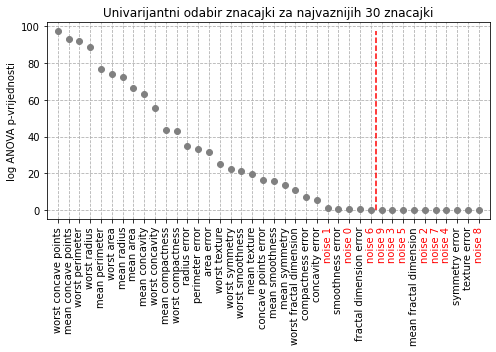

In [27]:
plt.figure(figsize=(7,5))

plt.plot(range(X_train.shape[1]), scores[indices], 'o', color='gray')

plt.title('Univarijantni odabir znacajki za najvaznijih 30 znacajki')
plt.ylabel('log ANOVA p-vrijednosti')
plt.xlim([-1, X_train.shape[1]])
plt.xticks(range(X_train.shape[1]), breast_cancer_train.drop('target',axis=1).columns.values[indices], rotation=90)
plt.vlines(k_best-0.5, 0, np.max(scores), color='red', linestyle='--')
plt.grid(True,linestyle='--')
plt.tight_layout()

# Hack za bojanje noise znacajki u crveno
[ i.set_color("red") for i in plt.gca().get_xticklabels() if i.get_text()[:5] == 'noise' ]

plt.show()

Vidimo da su neke od naših stvarnih značajki rangirane lošije od lažnih značajki. Ovo nije iznenađujuće jer je riječ o značajkama koje su slabo informativne, bilo zato što su dosta opskurne (mean fractal dimension) ili zapravo kodiraju grešku neke druge značajke. Ovo još uvijek nije garancija da su navedene značajke beskorisne, ali može poslužiti kao jednostavni prvi korak u procesu odabira značajki.

**Vježba 3.1.** Umjesto odabira određenog broja ili određenog postotka najvažnijih značajki možemo odabrati gornju granicu na udio *lažnih otkrića* (engl. false discoveries) - značajki za koje vjerujemo da su statistički povezane s ciljnom varijablom a da to zapravo nisu. Funkcija [`sklearn.feature_selection.SelectFdr`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFdr.html#sklearn.feature_selection.SelectFdr) odabire najvažnije značajke koristeći Benjamini-Hochberg proceduru uz očekivani udio lažnih otkrića `alpha` (engl. false discovery rate, FDR). Iskoristite ovu funkciju za odabir značajki uz FDR `alpha=0.05`. Napomena: Možete dobiti logičku masku za odabrane značajke pomoću funkcije `get_support()`.

In [28]:
from sklearn.feature_selection import SelectFdr, f_classif

In [29]:
breast_cancer = pd.read_csv('../assets/datasets/csv/breast_cancer.csv',index_col=0)

N_noise_features = 10
noise_features = pd.DataFrame(np.random.randn(breast_cancer.shape[0],N_noise_features),
                              index=breast_cancer.index,
                              columns=['noise ' + str(i) for i in range(N_noise_features)])

breast_cancer_extended = pd.concat([breast_cancer, noise_features], axis=1)

breast_cancer_train, breast_cancer_test = train_test_split(breast_cancer_extended, test_size=0.20, random_state=42)

X_train = breast_cancer_train.drop('target',axis=1)
y_train = breast_cancer_train['target']

k_best = 30
selector = SelectFdr(f_classif, alpha=0.05)
selector.fit(X_train, y_train)
scores = -np.log10(selector.pvalues_)
indices = np.argsort(scores)[::-1] # Vrati indekse koji sortiraju polje (obratno)

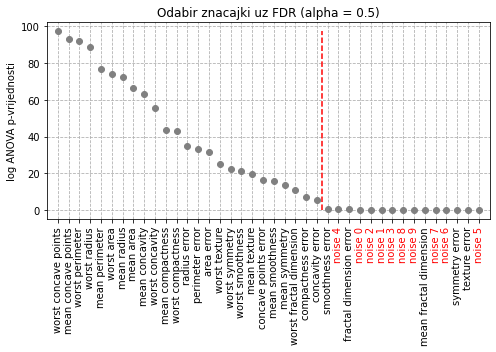

In [30]:
plt.figure(figsize=(7,5))

plt.plot(range(X_train.shape[1]), scores[indices], 'o', color='gray')

plt.title('Odabir znacajki uz FDR (alpha = 0.5)')
plt.ylabel('log ANOVA p-vrijednosti')
plt.xlim([-1, X_train.shape[1]])
plt.xticks(range(X_train.shape[1]), breast_cancer_train.drop('target',axis=1).columns.values[indices], rotation=90)
plt.vlines(np.sum(selector.get_support())-0.5, 0, np.max(scores), color='red', linestyle='--')
plt.grid(True,linestyle='--')
plt.tight_layout()

# Hack za bojanje noise znacajki u crveno
[ i.set_color("red") for i in plt.gca().get_xticklabels() if i.get_text()[:5] == 'noise' ]

plt.show()

**Vježba 3.2.** U prošlom primjeru koristili smo podatke s kategorijskom ciljnom varijablom. Odaberite skup podataka s numeričkom ciljnom varijablom i provedite univarijantni odabir značajki koristeći neku od regresijskih evaluacijskih mjera, primjerice [`sklearn.feature_selection.f_regression`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html#sklearn.feature_selection.f_regression). Za skup podataka možete koristiti neki od skupova dostupnih u [`sklearn.datasets`](http://scikit-learn.org/dev/modules/classes.html#module-sklearn.datasets), primjerice [`sklearn.datasets.load_diabetes`](http://scikit-learn.org/dev/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes) ili [`sklearn.datasets.load_boston`](http://scikit-learn.org/dev/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston).

3.2. Odabir značajki uz pomoć prediktivnog modela
------------------------------------------------------

U sljedećem primjeru izračunat ćemo važnost značajki izravno koristeći metodu slučajnih šuma (engl. random forest classifier), implementiranu u funkciji [`sklearn.ensemble.RandomForestClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) (regresijska verzija je [`sklearn.ensemble.RandomForestRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor)), koja evaluira važnost značajki preko pozicije u stablu gdje je značajka korištena kao split node. Značajke koje se nalaze bliže korjenu stabla imaju veći utjecaj na predikciju i prema tome se mogu smatrati važnijima.

In [31]:
from sklearn.ensemble import RandomForestClassifier

In [32]:
breast_cancer = pd.read_csv('../assets/datasets/csv/breast_cancer.csv',index_col=0)
breast_cancer_train, breast_cancer_test = train_test_split(breast_cancer, test_size=0.20, random_state=42)

forest = RandomForestClassifier(n_estimators=1000,random_state=0,n_jobs=-1) # Promjeni n_jobs za paralelizaciju!

X_train = breast_cancer_train.drop('target',axis=1)
y_train = breast_cancer_train['target']

forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1] # Vrati indekse koji sortiraju polje (obratno)

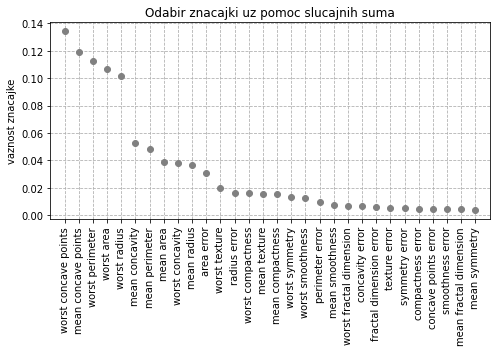

In [33]:
plt.figure(figsize=(7,5))

plt.plot(range(X_train.shape[1]), importances[indices], 'o', color='gray')

plt.title('Odabir znacajki uz pomoc slucajnih suma')
plt.ylabel('vaznost znacajke')
plt.xlim([-1, X_train.shape[1]])
plt.xticks(range(X_train.shape[1]), breast_cancer_train.drop('target',axis=1).columns.values[indices], rotation=90)
plt.tight_layout()
plt.grid(True,linestyle='--')
plt.show()

**Vježba 3.3.** Svako stablo u ansamblu slučajnih šuma evaluira važnost svake značajke zasebno. U prijašnjem primjeru prikazali smo samo srednju vrijednost važnosti dobivenu od svih stabala. Izračunajte i prikažite standardnu devijaciju svih evaluacija. Napomena: Pojedinačna stabla su dostupna u varijabli `forest.estimators_`, i svako stablo zasebno sprema važnost svakog atributa u varijabli `feature_importances_`.

```Python
importances_std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
```

Možete koristiti [`matplotlib.pyplot.errorbar`](http://matplotlib.org/api/pyplot_api.html?highlight=errorbar#matplotlib.pyplot.errorbar) za prikaz standardne devijacije.

```Python
plt.errorbar(range(X_train.shape[1]), importances[indices], yerr=importances_std[indices], fmt='o')
```

Također, pogledajte primjer na scikit-learn stranici ["Feature importances with forests of trees"](http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#example-ensemble-plot-forest-importances-py).

**Vježba 3.4.** Iskoristite neki drugi klasifikator za evaluaciju važnosti atributa, primjerice SVM klasifikator implementiran u [`sklearn.svm.SVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html). SVM računa $k-1$ zasebnih važnosti značajki, gdje je $k$ broj klasa, koje su spremljene u varijabli `coef_` (u našem skupu imamo samo dvije klase pa ćemo dobiti samo jednu procjenu važnosti za svaku od značajki). Napomena: U gornjoj implementaciji SVM-a važnosti atributa su dostupne samo za linearni kernel. Također, funkcija [`sklearn.svm.SVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) koristi [LIBSVM](http://www.csie.ntu.edu.tw/~cjlin/libsvm/) implementaciju SVM-a. Kao alternativu možete koristiti funkciju [`sklearn.svm.LinearSVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) koja koristi [LIBLINEAR](http://www.csie.ntu.edu.tw/~cjlin/liblinear/) implementaciju. Ta implementacija pruža samo linearni kernel ali nudi bolje performanse na velikom broju primjera.

In [34]:
from sklearn.svm import SVC

In [35]:
svc = SVC(kernel='linear')

X_train = breast_cancer_train.drop('target',axis=1).values
y_train = breast_cancer_train['target'].values

svc.fit(X_train, y_train);

importances_svc = svc.coef_.flatten() # Posto imamo samo dvije klase imamo samo jedan skup vaznosti znacajki
indices_svc = np.argsort(importances_svc)[::-1] # Vrati indekse koji sortiraju polje (obratno)

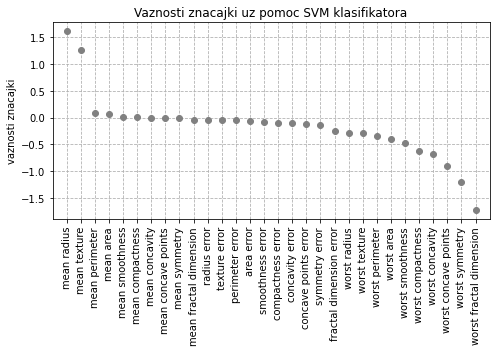

In [60]:
plt.figure(figsize=(7,5))

plt.plot(range(X_train.shape[1]), importances_svc[indices_svc], 'o', color='gray')

plt.title('Vaznosti znacajki uz pomoc SVM klasifikatora')
plt.ylabel('vaznosti znacajki')
plt.xlim([-1, X_train.shape[1]])
plt.xticks(range(X_train.shape[1]), breast_cancer.drop('target',axis=1).columns.values, rotation=90)
plt.tight_layout()
plt.grid(True,linestyle='--')
plt.show()

3.3. Rekurzivna eliminacija značajki
--------------------------------------------

Procedura za rekurzivnu eliminaciju značajki (engl. recursive feature elimination), također znana i kao selekcija unazad (engl. backward selection), je sljedeća. Prvo, evaluiraj važnost značajki koristeći dataset sa svim značajkama, potom iterativno eliminiraj najlošije rangirane značajke i ponovi evaluaciju. Procedura se ponavlja dok ne ostane željeni broj značajki. Primjetite da je ovo jednostavna pohlepna strategija koja ne garantira nalaženje najboljeg mogućeg skupa značajki određene veličine.

Slična procedura je i selekcija unaprijed (engl. forward selection), s iznimkom da se počinje s praznim skupom značajki nakon čega se značajke dodaju jedna po jedna dok se ne distigne željeni broj. Nažalost, ova procedura nije implementirana u scikit-learnu.

Koristit ćemo funkciju [`sklearn.feature_selection.RFE`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE) za rekurzivnu eliminaciju značajki. Sljedeći primjer je inspiriran poglavljem ["Recursive feature elimination"](http://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_digits.html#example-feature-selection-plot-rfe-digits-py) iz scikit-learn korisničke dokumentacije. Rekurzivna eliminacija značajki radi na bilo kojem prediktivnom modelu koji dodjeljuje važnosti značajkama. U sljedećem primjeru koristit ćemo klasifikator slučajnih šuma implementiranom u [`sklearn.ensemble.RandomForestClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier).

In [46]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

In [47]:
breast_cancer = pd.read_csv('../assets/datasets/csv/breast_cancer.csv',index_col=0)
breast_cancer_train, breast_cancer_test = train_test_split(breast_cancer, test_size=0.20, random_state=42)

X_train = breast_cancer_train.drop('target',axis=1)
y_train = breast_cancer_train['target']

rfe_rf = RFE(RandomForestClassifier(n_estimators=100,random_state=0,n_jobs=-1), n_features_to_select=10, step=1)
rfe_rf.fit(X_train, y_train);

In [48]:
print('Znacajke odabrane s RFE (koristeci slucajne sume):')
for i in list(breast_cancer_train.columns.values[:-1][rfe_rf.get_support()]):
    print(' - ' + str(i))

Znacajke odabrane s RFE (koristeci slucajne sume):
 - mean texture
 - mean area
 - mean concavity
 - mean concave points
 - worst radius
 - worst texture
 - worst perimeter
 - worst area
 - worst concavity
 - worst concave points


**Vježba 3.5.** Umjesto slučajnih šuma, iskoristite logističku regresiju implementiranu u [`sklearn.linear_model.LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) i stroj s potpornim vektorima implementiranom u [`sklearn.svm.SVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) za rekurzivnu eliminaciju značajki kako biste odabrali deset najvažnijih značajki. Usporedite tako dobivene značajke s onima dobivenima u prošlom primjeru.

In [49]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [50]:
breast_cancer = pd.read_csv('../assets/datasets/csv/breast_cancer.csv',index_col=0)
breast_cancer_train, breast_cancer_test = train_test_split(breast_cancer, test_size=0.20, random_state=42)

X_train = breast_cancer_train.drop('target',axis=1)
y_train = breast_cancer_train['target']

rfe_svc = RFE(SVC(kernel='linear'), n_features_to_select=10, step=1)
rfe_svc.fit(X_train, y_train);

rfe_lr = RFE(LogisticRegression(solver='liblinear'), n_features_to_select=10, step=1)
rfe_lr.fit(X_train, y_train);

In [51]:
print('Znacajke odabrane s RFE (koristeci SVC):')
for i in list(breast_cancer.columns.values[:-1][rfe_svc.get_support()]):
    print(' - ' + str(i))
    
print('\nZnacajke odabrane s RFE (koristeci logisticku regresiju):')
for i in list(breast_cancer.columns.values[:-1][rfe_lr.get_support()]):
    print(' - ' + str(i))

Znacajke odabrane s RFE (koristeci SVC):
 - mean radius
 - mean concavity
 - mean concave points
 - texture error
 - worst radius
 - worst smoothness
 - worst compactness
 - worst concavity
 - worst concave points
 - worst symmetry

Znacajke odabrane s RFE (koristeci logisticku regresiju):
 - mean radius
 - mean concavity
 - mean concave points
 - radius error
 - perimeter error
 - worst radius
 - worst perimeter
 - worst compactness
 - worst concavity
 - worst concave points


3.4. Rekurzivna eliminacija značajki s unakrsnom validacijom
--------------------------------------------

Prilikom rekurzivne eliminacije značajki trebali smo unaprijed definirati broj ili udio značajki koje želimo odabrati. Ali koliko značajki je optimalno? Bilo bi prikladnije kada bi algoritam mogao odabrati broj značajki za nas. Jedan od načina kako se to može napraviti je pomoću unakrsne validacije (engl. cross-validation). Važnost značajki se i dalje koristi za odabir značajki, ali optimalni broj značajki se bira unakrsnom validacijom. Za to ćemo koristiti funkciju [`sklearn.feature_selection.RFECV`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV) sa stratificiranom 2-fold unakrsnom validacijom implementiranom u [`sklearn.cross_validation.StratifiedKFold`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedKFold.html#sklearn.cross_validation.StratifiedKFold). Za ostale vrste unakrsne validacije dostupne u scikit-learnu pogledajte [`module-sklearn.cross_validation`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.cross_validation). Za sličan primjer pogledajte ["Recursive feature elimination with cross-validation"](http://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#example-feature-selection-plot-rfe-with-cross-validation-py) u scikit-learn korisničkoj dokumentaciji.

In [52]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

In [53]:
breast_cancer = pd.read_csv('../assets/datasets/csv/breast_cancer.csv',index_col=0)
breast_cancer_train, breast_cancer_test = train_test_split(breast_cancer, test_size=0.20, random_state=42)

X_train = breast_cancer_train.drop('target',axis=1)
y_train = breast_cancer_train['target']

rfecv_rf = RFECV(RandomForestClassifier(n_estimators=100,random_state=0,n_jobs=-1), 
                 step=1, 
                 cv=StratifiedKFold(n_splits=2),
                 scoring='accuracy')
rfecv_rf.fit(X_train, y_train);

In [54]:
print('Odabrane znacajke s RFECV (koristeci slucajne sume):')
for i in list(breast_cancer.columns.values[:-1][rfecv_rf.get_support()]):
    print(' - ' + str(i))

Odabrane znacajke s RFECV (koristeci slucajne sume):
 - mean radius
 - mean texture
 - mean perimeter
 - mean area
 - mean smoothness
 - mean concavity
 - mean concave points
 - radius error
 - area error
 - compactness error
 - concavity error
 - fractal dimension error
 - worst radius
 - worst texture
 - worst perimeter
 - worst area
 - worst smoothness
 - worst compactness
 - worst concavity
 - worst concave points
 - worst symmetry
 - worst fractal dimension


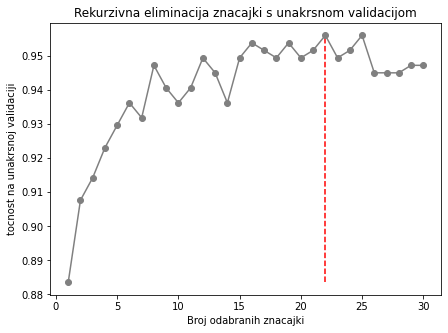

In [55]:
plt.figure(figsize=(7,5))

plt.plot(range(1, len(rfecv_rf.grid_scores_) + 1), rfecv_rf.grid_scores_, '-o',color='gray')
plt.xlabel('Broj odabranih znacajki')
plt.ylabel('tocnost na unakrsnoj validaciji')
plt.title('Rekurzivna eliminacija znacajki s unakrsnom validacijom')
plt.vlines(rfecv_rf.n_features_, 
           np.min(rfecv_rf.grid_scores_), 
           rfecv_rf.grid_scores_[rfecv_rf.n_features_-1], 
           color='red', linestyle='--')
plt.show()

**Vježba 3.6.** Umjesto slučajnih šuma i unakrsne validacije iskoristite neki drugi klasifikator i tip unakrsne validacije. Primjerice, za klasifikator možete iskoristiti SVM klasifikator implementiran u funkciji [`sklearn.svm.SVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) ili logističku regresiju implementiranu u funkciji [`sklearn.linear_model.LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression). Za unakrsnu validaciju možete iskoristiti leave-one-out unakrsnu validaciju implementiranu u [`sklearn.cross_validation.LeaveOneOut`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.LeaveOneOut.html#sklearn.cross_validation.LeaveOneOut) ili shuffle-split validaciju implementiranu u [`sklearn.cross_validation.ShuffleSplit`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.ShuffleSplit.html#sklearn.cross_validation.ShuffleSplit). Pogledajte [`module-sklearn.cross_validation`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.cross_validation) za sve vrste unakrsne validacije dostupne u scikit-learnu.

In [56]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [57]:
breast_cancer = pd.read_csv('../assets/datasets/csv/breast_cancer.csv',index_col=0)
breast_cancer_train, breast_cancer_test = train_test_split(breast_cancer, test_size=0.20, random_state=42)

X_train = breast_cancer_train.drop('target',axis=1)
y_train = breast_cancer_train['target']

rfecv_svc = RFECV(SVC(kernel='linear'), 
                 step=1, 
                 cv=StratifiedKFold(n_splits=2),
                 scoring='accuracy')
rfecv_svc.fit(X_train, y_train);

rfecv_lr = RFECV(LogisticRegression(solver='liblinear'), 
                 step=1, 
                 cv=StratifiedKFold(n_splits=2),
                 scoring='accuracy')
rfecv_lr.fit(X_train, y_train);

In [58]:
print('\nOdabrane znacajke s RFECV (koristeci SVC):')
for i in list(breast_cancer.columns.values[:-1][rfecv_svc.get_support()]):
    print(' - ' + str(i))
    
print('\nOdabrane znacajke s RFECV (koristeci logisticku regresiju):')
for i in list(breast_cancer.columns.values[:-1][rfecv_lr.get_support()]):
    print(' - ' + str(i))


Odabrane znacajke s RFECV (koristeci SVC):
 - mean radius
 - mean concavity
 - mean concave points
 - texture error
 - worst radius
 - worst smoothness
 - worst compactness
 - worst concavity
 - worst concave points
 - worst symmetry

Odabrane znacajke s RFECV (koristeci logisticku regresiju):
 - mean radius
 - mean texture
 - mean perimeter
 - mean smoothness
 - mean compactness
 - mean concavity
 - mean concave points
 - mean symmetry
 - mean fractal dimension
 - radius error
 - texture error
 - perimeter error
 - area error
 - concavity error
 - concave points error
 - symmetry error
 - worst radius
 - worst texture
 - worst perimeter
 - worst area
 - worst smoothness
 - worst compactness
 - worst concavity
 - worst concave points
 - worst symmetry
 - worst fractal dimension


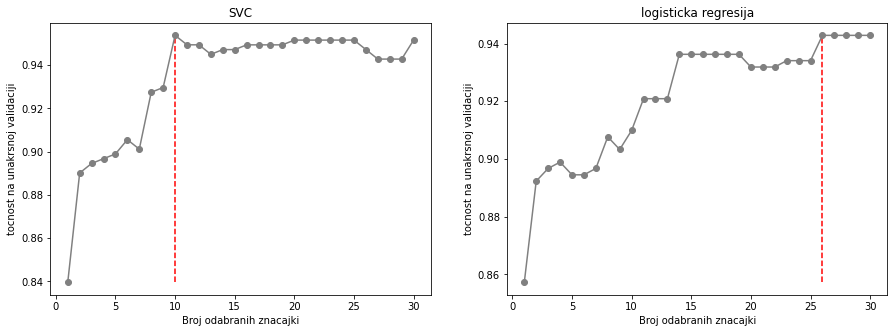

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(range(1, len(rfecv_svc.grid_scores_) + 1), rfecv_svc.grid_scores_, '-o', color='gray')
ax[0].set(xlabel='Broj odabranih znacajki',ylabel='tocnost na unakrsnoj validaciji',title='SVC')
ax[0].vlines(rfecv_svc.n_features_, 
             np.min(rfecv_svc.grid_scores_), 
             rfecv_svc.grid_scores_[rfecv_svc.n_features_-1], 
             color='red', linestyle='--')

ax[1].plot(range(1, len(rfecv_lr.grid_scores_) + 1), rfecv_lr.grid_scores_, '-o', color='gray')
ax[1].set(xlabel='Broj odabranih znacajki',ylabel='tocnost na unakrsnoj validaciji',title='logisticka regresija')
ax[1].vlines(rfecv_lr.n_features_, 
             np.min(rfecv_lr.grid_scores_), 
             rfecv_lr.grid_scores_[rfecv_lr.n_features_-1], 
             color='red', linestyle='--')

plt.show()

Literatura
-----------

<a name="scikit-feature-selection">[1]</a> *"scikit-learn documentation - 1.13. Feature selection"*, [link](http://scikit-learn.org/stable/modules/feature_selection.html#feature-selection)

<a name="pyml-ch4">[2]</a> *"Python Machine Learning Code examples - Chapter 4 - Building Good Training
Sets – Data Preprocessing"*, [link](https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch04/ch04.ipynb)

<a name="intro-ml-py-ch5">[3]</a> *"Introduction to Machine Learning with Python - Chapter 5 - Representing data and engineering features"* 

<a name="diving-into-data">[4]</a> *"Diving into data - Selecting good features"*, [part 1](http://blog.datadive.net/selecting-good-features-part-i-univariate-selection/), [part 2](http://blog.datadive.net/selecting-good-features-part-ii-linear-models-and-regularization/), [part 3](http://blog.datadive.net/selecting-good-features-part-iii-random-forests/), [part 4](http://blog.datadive.net/selecting-good-features-part-iv-stability-selection-rfe-and-everything-side-by-side/) 